URL: https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset/data

https://www.kaggle.com/code/jiinpp/eda-xgb-rf-logistic

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1UWCvchEmWW83mlUJ3ufHkl6MOfgVhuR_'
output = 'Online_Payment_Fraud_Detection.csv'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1UWCvchEmWW83mlUJ3ufHkl6MOfgVhuR_
From (redirected): https://drive.google.com/uc?id=1UWCvchEmWW83mlUJ3ufHkl6MOfgVhuR_&confirm=t&uuid=49a393ab-ab95-4252-9f30-c77c9e2568ce
To: /content/Online_Payment_Fraud_Detection.csv
100%|██████████| 494M/494M [00:07<00:00, 70.1MB/s]


'Online_Payment_Fraud_Detection.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns


total_subset_size = 200000
chunk_size = 50000

fraud_data = []
non_fraud_data = []

# Bucle para leer el archivo en chunks o trozos por separado.
for chunk in pd.read_csv(output, chunksize = chunk_size):
    # Filtrar los datos donde "isFraud" = 1
    fraud_chunk = chunk[chunk['isFraud'] == 1]
    fraud_data.append(fraud_chunk)

    # Filtrar los datos donde "isFraud" != 1
    non_fraud_chunk = chunk[chunk['isFraud'] != 1]
    non_fraud_data.append(non_fraud_chunk)

fraud_data = pd.concat(fraud_data)
non_fraud_data = pd.concat(non_fraud_data)
# El tamaño del DataFrame final incluirá un número de datos no fraudulentos igual al tamaño del subconjunto especificado menos el número de casos fraudulentos.
non_fraud_subset_size = total_subset_size - len(fraud_data)

if non_fraud_subset_size > 0:
  # Selección de datos no fraudulentos hasta completar su amaño específico.
    non_fraud_data_sample = non_fraud_data.sample(n=non_fraud_subset_size)
    data = pd.concat([fraud_data, non_fraud_data_sample])
else:
    data = fraud_data.sample(n = total_subset_size)

In [ ]:
data.head(6)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.00,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.00,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.00,1,0
681,1,CASH_OUT,20128.0,C1118430673,20128.0,0.0,C339924917,6268.0,12145.85,1,0


In [ ]:
data.shape[0]

200000

In [ ]:
fraud_cases = data[data["isFraud"]== 1]

In [ ]:
fraud_cases.shape[0]

8213

#ANÁLISIS SUPERFICIAL

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 2 to 5874415
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            200000 non-null  int64  
 1   type            200000 non-null  object 
 2   amount          200000 non-null  float64
 3   nameOrig        200000 non-null  object 
 4   oldbalanceOrg   200000 non-null  float64
 5   newbalanceOrig  200000 non-null  float64
 6   nameDest        200000 non-null  object 
 7   oldbalanceDest  200000 non-null  float64
 8   newbalanceDest  200000 non-null  float64
 9   isFraud         200000 non-null  int64  
 10  isFlaggedFraud  200000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 18.3+ MB


In [ ]:
data.describe() #TODAS LAS COULUMNAS SON IMPORTANTES

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,200000.000000,200000.000000
mean,248.503165,2.298431e+05,8.582984e+05,8.202640e+05,1.079413e+06,1.226146e+06,0.041065,0.000080
std,148.041103,7.840913e+05,2.903934e+06,2.875967e+06,3.464901e+06,3.731654e+06,0.198441,0.008944
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,156.000000,1.413935e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,250.000000,7.997226e+04,1.723400e+04,0.000000e+00,1.121046e+05,2.077900e+05,0.000000,0.000000
75%,347.000000,2.197505e+05,1.346490e+05,1.270585e+05,9.094065e+05,1.109343e+06,0.000000,0.000000
max,743.000000,5.072328e+07,5.958504e+07,4.958504e+07,3.249151e+08,3.555534e+08,1.000000,1.000000


In [ ]:
data.describe(include='object').T #EN ESTE CASO PUEDE SER INTERESANTE MAS ADELANTE LOS NOMBRES

,count,unique,top,freq
type,200000,5,CASH_OUT,71396
nameOrig,200000,199985,C543883779,2
nameDest,200000,174990,C977993101,9


#LIMPIEZA

In [ ]:
list_columns = data.columns.tolist()

num_columns = data.select_dtypes(include=["float64", "int64"]).columns.tolist()
print("Columnas numéricas: ", num_columns)

cat_columns = data.select_dtypes(include=["object"]).columns.tolist()
print("Columnas categóricas: ", cat_columns)

Columnas numéricas:  ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
Columnas categóricas:  ['type', 'nameOrig', 'nameDest']


In [ ]:
#VALORES NULOS
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
# duplicados
data.duplicated().sum()

0

In [ ]:
data.shape

(200000, 11)

In [ ]:
#OUTLIERS
def contador_outliers(df):
  columnas_seleccionadas = df.select_dtypes(include=['int64', 'float64']).\
  loc[:, df.nunique()>50]
  cuenta_outliers = {}
  for columna in columnas_seleccionadas.columns:
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    contador_outliers = ((df[columna] < lower_bound) | (df[columna] > upper_bound)).sum()
    cuenta_outliers[columna] = contador_outliers
  return pd.DataFrame.from_dict(cuenta_outliers, orient='index', columns=['Outliers Count'])
contador_outliers(data)#El tratamiento de outliers no resulta conveniente para la naturaleza de este dataset

,Outliers Count
step,3911
amount,12935
oldbalanceOrg,34915
newbalanceOrig,33874
oldbalanceDest,24955
newbalanceDest,23397


#EDA

In [ ]:
"""estas columnas tienen sin sentidos en las operaciones que no hacen mucho caso al mundo real, vamos a estudiar por qué
amount
oldbalanceOrg
newbalanceOrig
oldbalanceDest
newbalanceDest"""
plt.style.use('ggplot') #nos permitirá hacer gráficos despues de llamar a otros métodos
df = data.copy() #asi escribimos menos
df.shape

(200000, 11)

##Nombres

In [ ]:
df['nameDest'].describe(include='object')
#hay 30k nombres que reaparecen en el dataset sin embargo la mayor cantidad de apariciones es 7, por lo tanto no aportan mucha información

count         200000
unique        174990
top       C977993101
freq               9
Name: nameDest, dtype: object

In [ ]:
df['nameOrig'].describe(include='object')
#Solo 10 se repiten, y cada uno de esos 10 se repite solo una vez, no aportan mucha información

count         200000
unique        199985
top       C543883779
freq               2
Name: nameOrig, dtype: object

##step

In [ ]:
step_frec = df['step'].value_counts().sort_index() #Contamos la cantidad de veces que aparece cada Nº de steps para separarlos en dias, semanas y mes

horas = []
dias = []
semana_1 = []
semana_2 = []
semana_3 = []
semana_4 = []
meses = []

for steps in step_frec:
  if steps < 24:
    horas.append(steps)
  elif 24 <= steps < 168:
    dias.append(steps)
  elif 168 <= steps < 336:
    semana_1.append(steps)
  elif 168 <= steps < 336:
    semana_2.append(steps)
  elif 336 <= steps < 504:
    semana_3.append(steps)
  elif 504 <= steps < 672:
    semana_4.append(steps)
  else:
    meses.append(steps)

horas = pd.Series(horas)
dias = pd.Series(dias)
semana_1 = pd.Series(semana_1)
semana_2 = pd.Series(semana_2)
semana_3 = pd.Series(semana_3)
semana_4 =pd.Series(semana_4)
meses = pd.Series(meses)

df_steps = pd.concat([horas, dias, semana_1, semana_2, semana_3, semana_4, meses], axis=1).reset_index(drop=True)
df_steps.columns = ['horas', 'dias', 'semana_1', 'semana_2', 'semana_3', 'semana_4', 'meses']

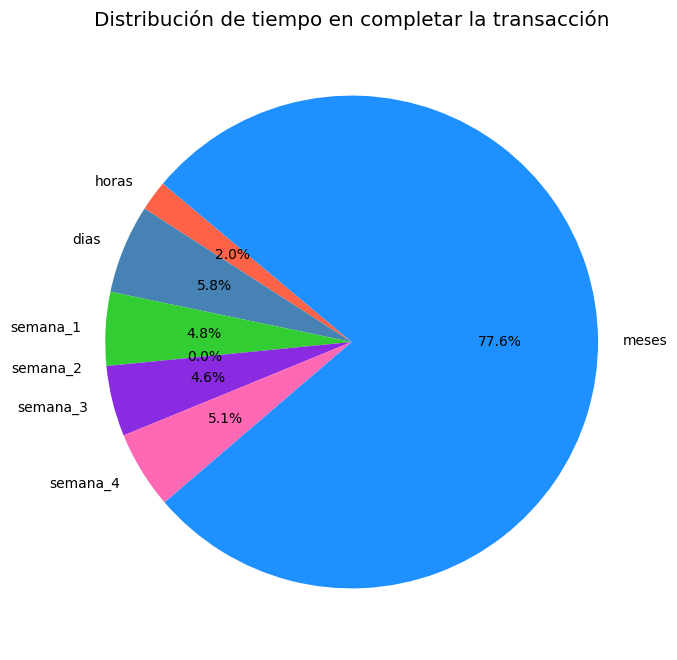

In [ ]:
sumarizado = df_steps.sum()
colores = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2', '#FF69B4', '#1E90FF']
plt.figure(figsize=(8, 8))
plt.pie(sumarizado, labels=sumarizado.index, autopct='%1.1f%%', startangle=140, colors=colores)
plt.title('Distribución de tiempo en completar la transacción')
plt.show() #NINGUNA TARDÓ EL TIEMPO ENTRE DOS SEMANAS: OSEA ENTRE 168 Y 336 HORAS!!

##Fraude y alerta de fraude

In [ ]:
df['isFraud'].value_counts() #8k fraudes escogidos para estudiar este dataset

isFraud
0    191787
1      8213
Name: count, dtype: int64

In [ ]:
df['isFlaggedFraud'].value_counts() #Solo 16 datos de 200k?

isFlaggedFraud
0    199984
1        16
Name: count, dtype: int64

In [ ]:
fraud_correctly = df[(df['isFraud']==1) & (df['isFlaggedFraud']==1)]
fraud_correctly['isFraud'].value_counts()
#Todo lo que se ha marcado como posible fraude (16) ha sido fraude (16 también) lo que significa que hay 8197 fraudes no detectados

isFraud
1    16
Name: count, dtype: int64

In [ ]:
#isFlaggedFraud no aporta nada importante, ademas estamos dando información que el modelo tendrá que buscar
df.drop(columns=['isFlaggedFraud'], inplace=True)

##amount

In [ ]:
df['amount'].describe()

count    2.000000e+05
mean     2.298431e+05
std      7.840913e+05
min      0.000000e+00
25%      1.413935e+04
50%      7.997226e+04
75%      2.197505e+05
max      5.072328e+07
Name: amount, dtype: float64

<Figure size 1000x800 with 0 Axes>

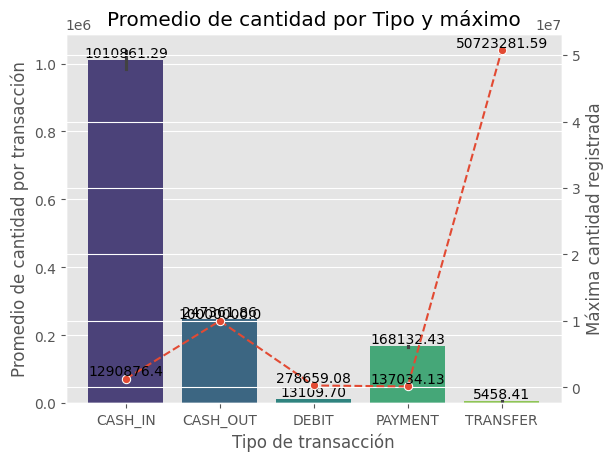

In [ ]:
plt.figure(figsize=(10, 8))
fig, ax1 = plt.subplots()
ax1=sns.barplot(x='type', y='amount', data=df, estimator='mean', palette='viridis')
plt.title('Promedio de cantidad por Tipo y máximo')
plt.xlabel('Tipo de transacción')
plt.ylabel('Promedio de cantidad por transacción')
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.2f}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='center',
                     xytext=(0, 5),  # Desplazamiento del texto
                     textcoords='offset points')

maximos = df.groupby('type')['amount'].max().reset_index()

ax2 = ax1.twinx()
ax2 = sns.lineplot(x='type', y='amount', data=maximos, marker='o', linestyle='--')

for index, row in maximos.iterrows():
    plt.text(row['type'], row['amount'], f'{row["amount"]}',
             color='black', ha='center', va='bottom')


plt.ylabel('Máxima cantidad registrada')
plt.show()

#Para este dataset la mayor frecuencia en las operaciones la tiene CASH IN y la cantidad mas grande de los 5 tipos types la tiene la transferencia

##type

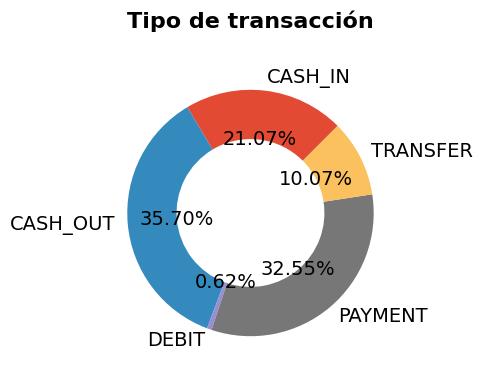

In [ ]:
plt.figure(figsize=(8, 4)) #Débito es casi irrelevante debido a la poca cantidad de datos.
values=df.groupby('type').size()
labels = values.index
plt.title('Tipo de transacción\n', fontsize = 16, fontweight = 'bold')
plt.pie(values, labels=labels, autopct='%1.2f%%', textprops={'fontsize': 14}, startangle=45, wedgeprops=dict(width=0.4));

##Análisis de los balances

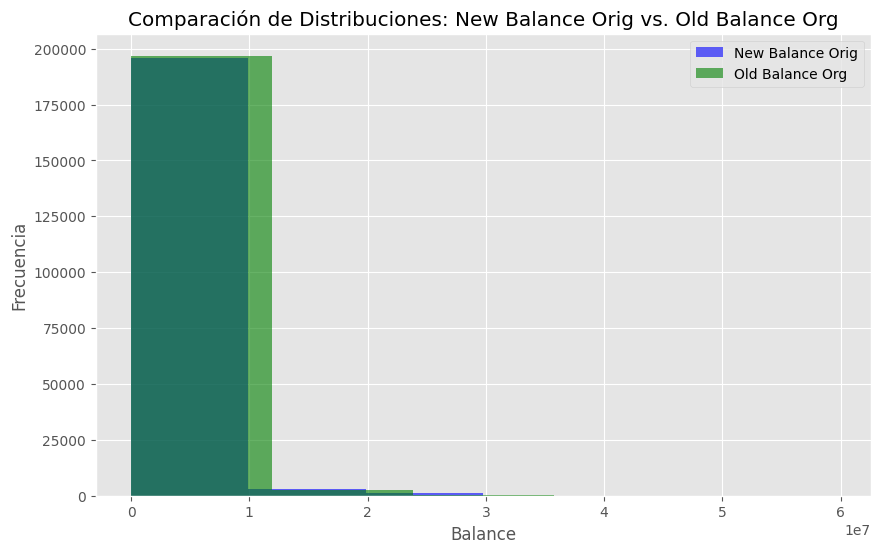

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['newbalanceOrig'], bins=5, color='blue', alpha=0.6, label='New Balance Orig')
plt.hist(df['oldbalanceOrg'], bins=5, color='green', alpha=0.6, label='Old Balance Org')
plt.xlabel('Balance')
plt.ylabel('Frecuencia')
plt.title('Comparación de Distribuciones: New Balance Orig vs. Old Balance Org')
plt.legend()

plt.show() #El 90% de los balances está debajo de los 10M de USD el resto son Outliers

##Ceros donde no deberían

In [ ]:
#Hay operaciones que empezaron en cero y terminaron en 0 para ambos lados
conteo_ceros_antes_org = (df['oldbalanceOrg'] == 0.0).sum()
conteo_ceros_antes_dest = (df['oldbalanceDest'] == 0.0).sum()
conteo_ceros_despues_org = (df['newbalanceOrig'] == 0.0).sum()
conteo_ceros_despues_dest = (df['newbalanceDest'] == 0.0).sum()
conteo_ceros_raro = ((df['oldbalanceOrg'] == 0.0) & (df['newbalanceOrig'] == 0.0)).sum()
conteo_ceros_muyraro = ((df['oldbalanceOrg'] == 0.0) & (df['newbalanceDest'] == 0.0)).sum()
conteo_ceros_amount = (df['amount'] == 0.0).sum()

print('Operaciones que empezaron en el origen con 0 en el balance:\n', conteo_ceros_antes_org)
print('Operaciones a destino 0 en el balance: ',conteo_ceros_antes_dest)
print('Operaciones que terminaron en el origen con 0 en el balance:\n',conteo_ceros_despues_org)
print('Operaciones a destino que terminaron con 0 en el balance:\n',conteo_ceros_despues_dest)
print('Operaciones que empezaron y terminaron en el origen con 0 en el balance:\n',conteo_ceros_raro)
print('Operaciones que empezaron en el origen con 0 en el balance y terminaron en 0 en el destino:\n',conteo_ceros_muyraro)
print('Operaciones de cantidad 0 desplazada:\n',conteo_ceros_amount)

Operaciones que empezaron en el origen con 0 en el balance:
 63139
Operaciones a destino 0 en el balance:  87033
Operaciones que terminaron en el origen con 0 en el balance:
 116474
Operaciones a destino que terminaron con 0 en el balance:
 77685
Operaciones que empezaron y terminaron en el origen con 0 en el balance:
 62745
Operaciones que empezaron en el origen con 0 en el balance y terminaron en 0 en el destino:
 23382
Operaciones de cantidad 0 desplazada:
 16


In [ ]:
dfconteo_ceros_raro = df[(df['oldbalanceOrg'] == 0.0) & (df['newbalanceOrig'] == 0.0)]
dfconteo_ceros_raro['isFraud'].value_counts() #Salió en 0 y terminó en 0 el origen

isFraud
0    62704
1       41
Name: count, dtype: int64

In [ ]:
dfconteo_ceros_muyraro = df[(df['oldbalanceOrg'] == 0.0) & (df['newbalanceDest'] == 0.0)]
dfconteo_ceros_muyraro['isFraud'].value_counts() #Salió en 0 y el destinatario terminó en 0

isFraud
0    23376
1        6
Name: count, dtype: int64

In [ ]:
dfconteo_ceros_amount = df[df['amount'] == 0.0]
dfconteo_ceros_amount['isFraud'].value_counts()
#Son fraude! Todas aquellas operaciones que se realizaron con cantidad 0

isFraud
1    16
Name: count, dtype: int64

In [ ]:
dfconteo_ceros_amount['type'].unique() #Todos los fraudes de cantidad 0 son CASH OUT!!

array(['CASH_OUT'], dtype=object)

In [ ]:
dfconteo_ceros_amount['nameOrig'].unique() #No se repite el origen en ningún fraude

array(['C1510987794', 'C521393327', 'C539112012', 'C1294472700',
       'C832555372', 'C69493310', 'C10965156', 'C1303719003',
       'C1971175979', 'C2060908932', 'C1997645312', 'C1960007029',
       'C1461113533', 'C729003789', 'C2088151490', 'C312737633'],
      dtype=object)

In [ ]:
dfconteo_ceros_amount['nameDest'].unique() #No se repite el destinatario en ningún fraude

array(['C1696624817', 'C480398193', 'C1106468520', 'C1325541393',
       'C1462759334', 'C719711728', 'C1493336195', 'C900608348',
       'C1352345416', 'C1587892888', 'C601248796', 'C459118517',
       'C1382150537', 'C1388096959', 'C1156763710', 'C1400061387'],
      dtype=object)

##Hay negativos?

In [ ]:
#Con esto demostramos que no hay cantidades negativas en ninguna operación
conteo_negativos_antes_org = (df['oldbalanceOrg'] < 0.0).sum()
conteo_negativos_antes_dest = (df['oldbalanceDest'] < 0.0).sum()
conteo_negativos_despues_org = (df['newbalanceOrig'] < 0.0).sum()
conteo_negativos_despues_dest = (df['newbalanceDest'] < 0.0).sum()
conteo_negativos_amount = (df['amount'] < 0.0).sum()

print(conteo_negativos_antes_org)
print(conteo_negativos_antes_dest)
print(conteo_negativos_despues_org)
print(conteo_negativos_despues_dest)
print(conteo_negativos_amount)

0
0
0
0
0


##Matriz de correlación

<Axes: >

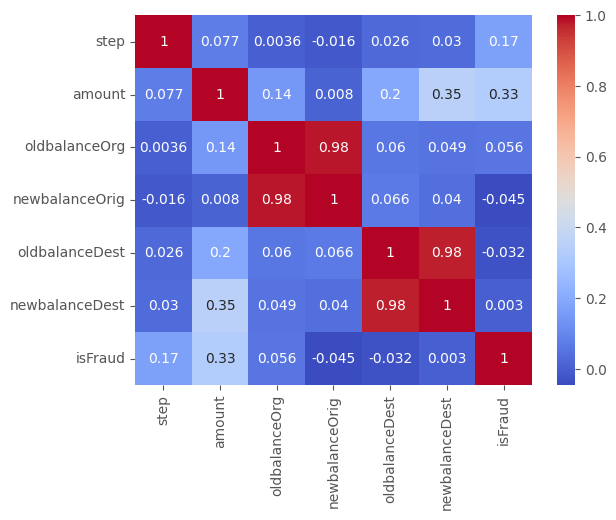

In [ ]:
df_var_num = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].copy()
sns.heatmap(df_var_num.corr(),annot=True, cmap='coolwarm')
#Como era de esperarse las variables que mas se correlacionan son los balances antes y después, seguidos de la cantidad para el fraude

#MODELOS DE MACHINE LEARNING
Tengamos en cuenta que nos interesa saber si hay fraude o no (clasificación) por lo tanto está muy claro que la variable objetivo es 'isFraud'.
Haremos un sample para todos los modelos de 8k fraude y 8k no fraude.
Luego usaremos un predict con los 200k.
Por tanto los modelos que mejores resultados nos darán serán:
*   Regresión Logística
*   AdaBoost
* Random Forest





In [ ]:
#filtrado de si es fraude (1) o no (0)
fraude_df = df[df['isFraud'] == 1]
no_fraude_df = df[df['isFraud'] == 0]
#muestreo de 8k fraude y 8k no fra
sample_fraude = fraude_df.sample(n=8000, random_state=42)
sample_no_fraude = no_fraude_df.sample(n=8000, random_state=42)
#creamos el dataframe con el muestreo
sampled_df = pd.concat([sample_fraude, sample_no_fraude])
#Ahora mezclamos todo para que no exista un 'orden'
data = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
data = data.drop(['nameOrig', 'nameDest'], axis=1) #No nos interesa el nombre del destino ni el origen en este caso, mas adelantye si el modelo funciona bien detectaremos quién fué

In [ ]:
data['isFraud'].value_counts() #Hemos balanceado correcrtamente la muestra

isFraud
0    8000
1    8000
Name: count, dtype: int64

In [ ]:
num_columns = data.select_dtypes(include=["int64","float64"]).columns.tolist()
print("Columnas numéricas: ", num_columns)

cat_columns = data.select_dtypes(include=["object"]).columns.tolist()
print("Columnas categóricas: ", cat_columns)

Columnas numéricas:  ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']
Columnas categóricas:  ['type']


##REGRESIÓN LOGÍSTICA CON MUESTREO BALANCEADO

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression


# Crear el ColumnTransformer para aplicar OneHotEncoder a la columna 'type'
column_transformer = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['type'])],remainder='passthrough')

# Crear el Pipeline
pipeline = Pipeline(steps=[('preprocessor', column_transformer)])

# Ajustar y transformar los datos
transformed_data = pipeline.fit_transform(data)

# Primero obtenemos los nombres de las nuevas columnas generadas por OneHotEncoder
onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(['type'])
all_columns = list(onehot_columns) + [col for col in data.columns if col != 'type']

dataRL = pd.DataFrame(transformed_data, columns=all_columns)

num_columns_RL = dataRL.select_dtypes(include=["int64","float64"]).columns.tolist()
print("Columnas numéricas: ", num_columns_RL)

cat_columns_RL = dataRL.select_dtypes(include=["object"]).columns.tolist() #Si hemos transformado bien las columnas no quedarán categóricas
print("Columnas categóricas: ", cat_columns_RL)

Columnas numéricas:  ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']
Columnas categóricas:  []


###COLUMNA OBJETIVO, ESTANDARIZACIÓN Y PREPARACIÓN DEL MODELO

In [ ]:
target_column = "isFraud"

num_pred_columns = num_columns_RL
num_pred_columns.remove(target_column)
print("Columnas numéricas predictoras: ", num_pred_columns)

Columnas numéricas predictoras:  ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression

# Transformador para columnas numéricas.
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_pred_columns)])

# CREACIÓN DEL PIPELINE CON REGRESIÓN LOGÍSTICA
model = Pipeline([('preprocessor', preprocessor),('log_regressor', LogisticRegression())])


In [ ]:
X = dataRL.drop(columns=target_column)
y = dataRL[target_column]

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Tamaño datos de entrenamiento:", X_train.shape)
print("Tamaño datos de testeo:", X_test.shape)

Tamaño datos de entrenamiento: (12800, 11)
Tamaño datos de testeo: (3200, 11)


###VALIDACIÓN CRUZADA, ENTRENAMIENTO Y PREDICCIÓN

In [ ]:
# VALIDACIÓN CRUZADA
# Realizar K-Fold Cross-Validation con 5 folds. (esto nos ayudará a un uso eficiente del modelo y evitaremos a ser posible sobreajuste)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
print(f'Puntuaciones de Validación Cruzada: {np.round(cv_scores,2)}')
print(f'Promedio de las puntuaciones de Validación Cruzada: {round(np.mean(cv_scores),2)}')
print(f'Desviación Típica de las puntuaciones de Validación Cruzada: {round(np.std(cv_scores),2)}')

Puntuaciones de Validación Cruzada: [0.92 0.93 0.92 0.92 0.92]
Promedio de las puntuaciones de Validación Cruzada: 0.92
Desviación Típica de las puntuaciones de Validación Cruzada: 0.01


In [ ]:
#ENTRENAMIENTO DEL MODELO
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['type_CASH_IN',
                                                   'type_CASH_OUT',
                                                   'type_DEBIT', 'type_PAYMENT',
                                                   'type_TRANSFER', 'step',
                                                   'amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest'])])),
                ('log_regressor', LogisticRegression())])

In [ ]:
#TEST DEL MODELO
y_pred = model.predict(X_test)

###COEFICIENTES DE CADA COLUMNA

In [ ]:
# COEFICIENTES FINALES
# Acceder al modelo de regresión dentro del pipeline
log_regressor = model.named_steps['log_regressor']

# Obtener los coeficientes y el interceptor
coefficients = np.round(log_regressor.coef_)
intercept = np.round(log_regressor.intercept_)
feature_names = preprocessor.get_feature_names_out()
coef_dict = dict(zip(feature_names, coefficients.flatten()))
print("Interceptor del modelo:", intercept)
print("Coeficientes finales del modelo:", coef_dict)
#Las características que no influyen son débito con peso 0.0 y CASH OUT con -1
#Las características que más influyen son num__oldbalanceOrg con 23 y num__newbalanceOrig con -16
#El modelo de regresión logística parece indicar que la verdadera influencia de un posible fraude se encuentra en el balance del origen antes y después

Interceptor del modelo: [-0.]
Coeficientes finales del modelo: {'num__type_CASH_IN': -5.0, 'num__type_CASH_OUT': 2.0, 'num__type_DEBIT': -0.0, 'num__type_PAYMENT': -2.0, 'num__type_TRANSFER': 3.0, 'num__step': 1.0, 'num__amount': -3.0, 'num__oldbalanceOrg': 22.0, 'num__newbalanceOrig': -15.0, 'num__oldbalanceDest': 4.0, 'num__newbalanceDest': -6.0}


###EVALUACIÓN DEL MODELO

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# EVALUACIÓN DEL MODELO
accuracy = round(accuracy_score(y_test, y_pred),2)
precision = round(precision_score(y_test, y_pred),2)
recall = round(recall_score(y_test, y_pred),2)
f1 = round(f1_score(y_test, y_pred),2)
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
specificity = round(tn / (tn + fp),2)

print("Exactitud:", accuracy)
print("Precisión:", precision)
print("Sensibilidad:", recall)
print("Especificidad:", specificity)
print("F1 Score:", f1)
print("Matriz de Confusión:\n", conf_matrix)

Exactitud: 0.93
Precisión: 0.93
Sensibilidad: 0.92
Especificidad: 0.93
F1 Score: 0.93
Matriz de Confusión:
 [[1489  106]
 [ 124 1481]]


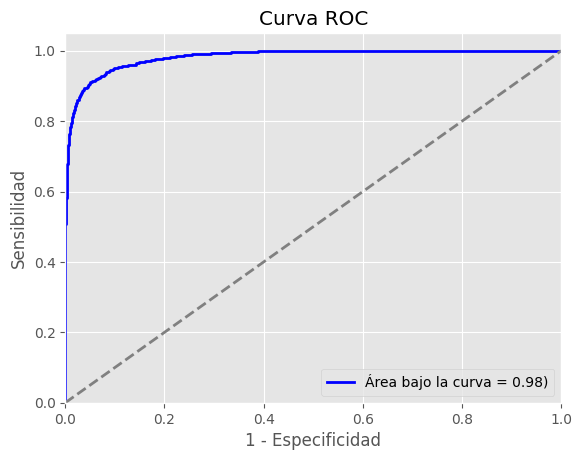

In [ ]:
# Calcular la curva ROC
y_prob = model.predict_proba(X_test)[:, 1] # predict_proba() devuelve las probabilidades para la clase positiva 1.
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Área bajo la curva = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Especificidad')
plt.ylabel('Sensibilidad')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

##REGRESION LOGÍSTICA TOTAL

###CODIFICACIÓN, ESTANDARIZACIÓN Y COLUMNA OBJETIVO

In [ ]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True) #nos servirá para los demás modelos
# Ajustar y transformar los datos
transformed_data = pipeline.fit_transform(df)

onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(['type'])
all_columns = list(onehot_columns) + [col for col in data.columns if col != 'type']

dfRL = pd.DataFrame(transformed_data, columns=all_columns)

num_columns_dfRL = dfRL.select_dtypes(include=["int64","float64"]).columns.tolist()
print("Columnas numéricas: ", num_columns_RL)

cat_columns_dfRL = dfRL.select_dtypes(include=["object"]).columns.tolist()
print("Columnas categóricas: ", cat_columns_RL)

Columnas numéricas:  ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
Columnas categóricas:  []


In [ ]:
target_columndf = "isFraud"

num_pred_columns = num_columns_dfRL
num_pred_columns.remove(target_columndf)
print("Columnas numéricas predictoras: ", num_pred_columns)

Columnas numéricas predictoras:  ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


In [ ]:
# Transformador para columnas numéricas.
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_pred_columns)])

###ENTRENAMIENTO Y PREDICCIÓN

In [ ]:
#ENTRENAMIENTO DEL MODELO para que no aprenda de la regresión anterior
samples_fraud = dfRL[dfRL['isFraud']==1].sample(n=2000, random_state=42)
no_samples_fraud = dfRL[dfRL['isFraud']==0].sample(n=2000, random_state=42)
real_training_samples = pd.concat([samples_fraud, no_samples_fraud])
datos_restantes = dfRL.drop(real_training_samples.index)

X_2k = real_training_samples.drop(columns=['isFraud'])
y_2k = real_training_samples['isFraud']

model.fit(X_2k, y_2k)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['type_CASH_IN',
                                                   'type_CASH_OUT',
                                                   'type_DEBIT', 'type_PAYMENT',
                                                   'type_TRANSFER', 'step',
                                                   'amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest'])])),
                ('log_regressor', LogisticRegression())])

In [ ]:
#TEST
X_200k = datos_restantes.drop(columns=['isFraud'])
y_200k = datos_restantes['isFraud']

y_pred_200k = model.predict(X_200k)

###EVALUACIÓN DEL MODELO

In [ ]:
# EVALUACIÓN DEL MODELO
accuracy = round(accuracy_score(y_200k, y_pred_200k),2)
precision = round(precision_score(y_200k, y_pred_200k),2)
recall = round(recall_score(y_200k, y_pred_200k),2)
f1 = round(f1_score(y_200k, y_pred_200k),2)
conf_matrix = confusion_matrix(y_200k, y_pred_200k)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
specificity = round(tn / (tn + fp),2)

print("Exactitud:", accuracy)
print("Precisión:", precision)
print("Sensibilidad:", recall)
print("Especificidad:", specificity)
print("F1 Score:", f1)
print("Matriz de Confusión:\n", conf_matrix) #No hay mayor cambio, solo la precision pero es normal al tener mas datos

Exactitud: 0.91
Precisión: 0.25
Sensibilidad: 0.91
Especificidad: 0.91
F1 Score: 0.39
Matriz de Confusión:
 [[172983  16804]
 [   568   5645]]


##RANDOM FOREST BALANCEADO

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer

dfRF = dfRL.copy() #Hacemos una copia para no tener que repetir las transformaciones

###COLUMNA OBJETIVO, PREDICTORAS Y PIPELINE DEL MODELO

In [ ]:
target_column = "isFraud"

pred_columns = [col for col in num_columns_RL if col != target_column]
num_pred_columns = [col for col in pred_columns if col in num_columns_RL]
cat_pred_columns = [col for col in pred_columns if col in cat_columns_RL]
print("Columnas predictoras: ", pred_columns)
print("Columnas numéricas predictoras: ", num_pred_columns)
print("Columnas categóricas predictoras: ", cat_pred_columns)

Columnas predictoras:  ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
Columnas numéricas predictoras:  ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
Columnas categóricas predictoras:  []


In [ ]:
model = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42, max_depth=None, oob_score=True)) # Random Forest para tareas de clasificación.
])
#ya tenemos nuestro df separado en 2k valores del modelo anterior, con asignar un nuevo valor a 'model' debe bastar

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

# CONFIGURACIÓN DE LA BÚSQUEDA DE HIPERPARÁMETROS
# Configurar la búsqueda por validación cruzada para encontrar el mejor valor de alpha
metaparameter_list = ['classifier__max_features', 'classifier__min_samples_split']
param_grid = {
    metaparameter_list[0]: ['sqrt', 'log2', None], # Las opciones es la raíz
    metaparameter_list[1]: [2, 5, 10],
}

# Configurar el GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, verbose = 1, scoring='f1_weighted')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2k, y_2k, test_size=0.2)
print("Tamaño datos de entrenamiento:", X_train.shape)
print("Tamaño datos de testeo:", X_test.shape)

Tamaño datos de entrenamiento: (3200, 11)
Tamaño datos de testeo: (800, 11)


###ENTRENAMIENTO DEL MODELO Y PREDICCIÓN

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(oob_score=True,
                                                               random_state=42))]),
             param_grid={'classifier__max_features': ['sqrt', 'log2', None],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='f1_weighted', verbose=1)

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

###EVALUACIÓN

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# EVALUACIÓN DEL MODELO
accuracy = round(accuracy_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)
conf_matrix = confusion_matrix(y_test, y_pred)
tree_model = best_model.named_steps['classifier']
oob_score = tree_model.oob_score_

print("Exactitud:", accuracy)
print("Precisión:", precision)
print("Sensibilidad:", recall)
print("F1 Score:", f1)
print(f"OOB Score: {oob_score:.2f}")
print("Matriz de Confusión:\n", conf_matrix)

Exactitud: 0.99
Precisión: 1.0
Sensibilidad: 0.99
F1 Score: 0.99
OOB Score: 0.99
Matriz de Confusión:
 [[401   1]
 [  4 394]]


In [ ]:
"""Solo en caso de que no tarde mucho
# LOCALIZACIÓN DEL PUNTO CRÍTICO
n_estimators_range = range(1, 101) # Rango en el número de estimadores a probar
train_errors = []
test_errors = []

# Extraer los mejores hiperparámetros
best_max_features = grid_search.best_params_['classifier__max_features']
best_min_samples_split = grid_search.best_params_['classifier__min_samples_split'] # Metaparámetros obtenido del mejor modelo obtenido en el GridSearch

# Este bucle entrena y evalua un Random Forest, cada uno con un número distinto de estimadores.
for n in n_estimators_range:
    clf = RandomForestClassifier(
        n_estimators=n,
        max_features = best_max_features,
        min_samples_split = best_min_samples_split,
        random_state=42,
    )
    clf.fit(X_train, y_train)

    # Obtenemos la medida del error, tanto para las muestras de entrenamiento como de testeo.
    train_errors.append(1 - f1_score(y_train, clf.predict(X_train)))
    test_errors.append(1 - f1_score(y_test, clf.predict(X_test)))

# Graficar los errores de entrenamiento y prueba
plt.figure(figsize=(8, 4))
plt.plot(n_estimators_range, train_errors, label='Error de Entrenamiento')
plt.plot(n_estimators_range, test_errors, label='Error de Prueba')
plt.xlabel('Número de Árboles')
plt.ylabel('Error')
plt.title('Error vs. Número de Árboles en el Random Forest')
plt.legend()
plt.show()
"""

"Solo en caso de que no tarde mucho\n# LOCALIZACIÓN DEL PUNTO CRÍTICO\nn_estimators_range = range(1, 101) # Rango en el número de estimadores a probar\ntrain_errors = []\ntest_errors = []\n\n# Extraer los mejores hiperparámetros\nbest_max_features = grid_search.best_params_['classifier__max_features']\nbest_min_samples_split = grid_search.best_params_['classifier__min_samples_split'] # Metaparámetros obtenido del mejor modelo obtenido en el GridSearch\n\n# Este bucle entrena y evalua un Random Forest, cada uno con un número distinto de estimadores.\nfor n in n_estimators_range:\n    clf = RandomForestClassifier(\n        n_estimators=n,\n        max_features = best_max_features,\n        min_samples_split = best_min_samples_split,\n        random_state=42,\n    )\n    clf.fit(X_train, y_train)\n\n    # Obtenemos la medida del error, tanto para las muestras de entrenamiento como de testeo.\n    train_errors.append(1 - f1_score(y_train, clf.predict(X_train)))\n    test_errors.append(1 - 

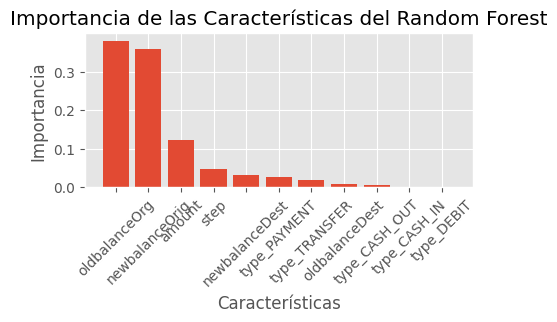

In [ ]:
# INTERPRETACIÓN DEL MODELO
# Extraemos las métricas de relevancia de cara característica.
importances = tree_model.feature_importances_
# Crear un DataFrame para visualizar las importancias
feature_importances = pd.DataFrame({'feature': pred_columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
# Graficar la importancia de las características
plt.figure(figsize=(5, 2))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las Características del Random Forest')
plt.xticks(rotation=45)
plt.show()

##RANDOM FOREST TOTAL

###PREDICCIÓN

In [ ]:
y_pred_RF = best_model.predict(X_200k)

###EVALUCAIÓN DEL MODELO

In [ ]:
accuracy = round(accuracy_score(y_200k, y_pred_RF), 2)
precision = round(precision_score(y_200k, y_pred_RF), 2)
recall = round(recall_score(y_200k, y_pred_RF), 2)
f1 = round(f1_score(y_200k, y_pred_RF), 2)
conf_matrix = confusion_matrix(y_200k, y_pred_RF)
tree_model = best_model.named_steps['classifier']
oob_score = tree_model.oob_score_

print("Exactitud:", accuracy)
print("Precisión:", precision)
print("Sensibilidad:", recall)
print("F1 Score:", f1)
print(f"OOB Score: {oob_score:.2f}")
print("Matriz de Confusión:\n", conf_matrix)

Exactitud: 0.99
Precisión: 0.72
Sensibilidad: 0.99
F1 Score: 0.84
OOB Score: 0.99
Matriz de Confusión:
 [[187423   2364]
 [    43   6170]]


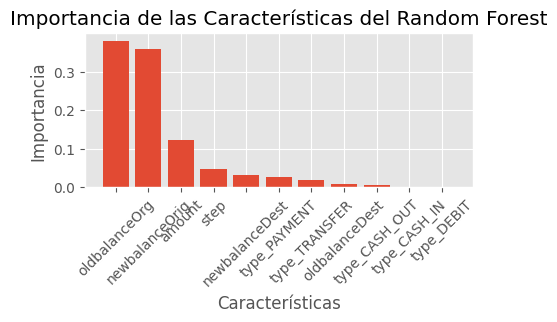

In [ ]:
#INTERPRETACIÓN DEL MODELO
importances = tree_model.feature_importances_

feature_importances = pd.DataFrame({'feature': pred_columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(5, 2))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las Características del Random Forest')
plt.xticks(rotation=45)
plt.show()
#Como habíamos visto en la matriz de correlación, el Random Foresty discrimina tomando en cuenta las columnas de los balances del origen

##AdaBoost BALANCEADO

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer

model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', AdaBoostClassifier(estimator = DecisionTreeClassifier()))])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2k, y_2k, test_size=0.2)

print("Tamaño datos de entrenamiento:", X_train.shape)
print("Tamaño datos de testeo:", X_test.shape)

Tamaño datos de entrenamiento: (3200, 11)
Tamaño datos de testeo: (800, 11)


In [ ]:
# CONFIGURACIÓN DE LA BÚSQUEDA DE HIPERPARÁMETROS
# Configurar la búsqueda por validación cruzada para encontrar los mejores valores de hiperparámetros.
metaparameter_list = ['classifier__n_estimators', 'classifier__learning_rate']
param_grid = {
    metaparameter_list[0]: [50, 70, 90, 120, 180, 200],
    metaparameter_list[1]: [0.001, 0.01, 0.1, 1, 10],
}

# Configurar el GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, verbose = 1, scoring='neg_mean_squared_error', error_score='raise')

###ENTRENAMIENTO Y PREDICCIÓN

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['type_CASH_IN',
                                                                          'type_CASH_OUT',
                                                                          'type_DEBIT',
                                                                          'type_PAYMENT',
                                                                          'type_TRANSFER',
                                                                          'step',
                                                                          'amount',
                                                                          'oldbalanceOrg',
                                                                          'newbalanceOrig',
                                                                          'oldbalanceDest',
                                                                          'newbalanceDest'])])),
                                       ('classifier',
                                        AdaBoostClassifier(estimator=DecisionTreeClassifier()))]),
             param_grid={'classifier__learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'classifier__n_estimators': [50, 70, 90, 120, 180,
                                                      200]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
best_modelXG = grid_search.best_estimator_
y_pred = best_modelXG.predict(X_test)

###EVALUACIÓN DEL MODELO

In [ ]:
# EVALUACIÓN DEL MODELO

accuracy = round(accuracy_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Exactitud:", accuracy)
print("Precisión:", precision)
print("Sensibilidad:", recall)
print("F1 Score:", f1)
print("Matriz de Confusión:\n", conf_matrix)

Exactitud: 0.98
Precisión: 0.99
Sensibilidad: 0.98
F1 Score: 0.98
Matriz de Confusión:
 [[398   4]
 [  9 389]]


##AdaBoost TOTAL


###PREDICCIÓN CON DATOS NO ENTRENADOS

In [ ]:
y_pred_XG = best_modelXG.predict(X_200k)

###EVALUACIÓN DEL MODELO

In [ ]:
accuracy = round(accuracy_score(y_200k, y_pred_XG), 2)
precision = round(precision_score(y_200k, y_pred_XG), 2)
recall = round(recall_score(y_200k, y_pred_XG), 2)
f1 = round(f1_score(y_200k, y_pred_XG), 2)
conf_matrix = confusion_matrix(y_200k, y_pred_XG)

print("Exactitud:", accuracy)
print("Precisión:", precision)
print("Sensibilidad:", recall)
print("F1 Score:", f1)
print("Matriz de Confusión:\n", conf_matrix)

Exactitud: 0.98
Precisión: 0.66
Sensibilidad: 0.98
F1 Score: 0.79
Matriz de Confusión:
 [[186609   3178]
 [   112   6101]]


##COMPARACION ENTRE LOS MODELOS Y CRITERIO PARA ESCOGER

Es importante tener en cuenta que son modelos para categorizar que por la naturaleza de los datos tendremos mayor consideración con algunas métricas que con otras:
*  Exactitud del modelo a la hora de separar Fraude de No fraude y curva ROC
*  Sensibilidad: El costo de un falso negativo es muy alto
*  Validación Cruzada y GridSearch
*  Tiempo y coste computacional
*  Facilidad para interpretar y overfitting

In [ ]:
data_balanceada = {'Modelo': ['Regresión Logística', 'Random Forest', 'AdaBoost'], 'Exactitud': [0.92, 0.99, 0.98], 'Sensibilidad': [0.92, 1.00, 0.98], 'Tendencia_sobreajuste': ['media', 'baja', 'baja']}
df_balanceada_modelos = pd.DataFrame(data_balanceada)
df_balanceada_modelos

,Modelo,Exactitud,Sensibilidad,Tendencia_sobreajuste
0,Regresión Logística,0.92,0.92,media
1,Random Forest,0.99,1.00,baja
2,AdaBoost,0.98,0.98,baja


In [ ]:
data_modelos = {'Modelo': ['Regresión Logística', 'Random Forest', 'AdaBoost'], 'Exactitud': [0.92, 0.99, 0.98], 'Sensibilidad': [0.91, 1.00, 0.98], 'Tendencia_sobreajuste': ['media', 'baja', 'baja'], 'Interpretación': ['alta', 'media', 'baja'], 'Costo-Tiempo': ['baja', 'media', 'media']}
df_modelos = pd.DataFrame(data_modelos)
df_modelos

,Modelo,Exactitud,Sensibilidad,Tendencia_sobreajuste,Interpretación,Costo-Tiempo
0,Regresión Logística,0.92,0.91,media,alta,baja
1,Random Forest,0.99,1.00,baja,media,media
2,AdaBoost,0.98,0.98,baja,baja,media


EL modélo de Random Forest es el que mejor clasifica los fraudes, por tanto es el modelo escogido.

#PRUEBAS ADICIONALES (Cluster)

In [ ]:
dfRL.drop(columns=['isFraud'], inplace=True) #dfRL ya está estandarizada y codificada

In [ ]:
print(dfRL.columns)

Index(['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest'],
      dtype='object')


In [ ]:
!pip install --q validclust

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from validclust import ValidClust

# CLUSTERIZACIÓN CON K-MEANS
n_clusters = 2

# Inicializar y ajustar el modelo K-Means
kmeans = KMeans(n_clusters= n_clusters, init='k-means++', random_state=42) # Definimos un objeto KMeans.
kmeans.fit(dfRL) # Generamos la clusterización.

# Creamos un nuevo DataFrame y guardamos en el las asignaciones a los clústers.
data_kmeans = pd.DataFrame(dfRL).copy()
data_kmeans["n_cluster"] = kmeans.labels_ # kmeans.labels_ guarda las asignaciones de clusters.
data_kmeans.head()


,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,n_cluster
0,0.0,0.0,0.0,0.0,1.0,1.0,181.0,181.0,0.0,0.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,1.0,181.0,181.0,0.0,21182.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,1.0,2806.0,2806.0,0.0,0.0,0.0,0
3,0.0,1.0,0.0,0.0,0.0,1.0,2806.0,2806.0,0.0,26202.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,1.0,20128.0,20128.0,0.0,0.0,0.0,0


In [ ]:
# OBTENCIÓN DE CENTROIDES
centroids = kmeans.cluster_centers_
print("Centroides:")
print(centroids)

Centroides:
[[1.70721856e-01 3.73789555e-01 6.79762322e-03 3.44972735e-01
  1.03718231e-01 2.48022136e+02 2.02364941e+05 3.09677757e+05
  2.78804714e+05 8.06986448e+05 9.40910872e+05]
 [8.54043559e-01 8.50075975e-02 1.43508357e-03 3.37666723e-04
  5.91760932e-02 2.51453318e+02 7.10289975e+05 9.83215985e+06
  9.69065119e+06 5.46056034e+06 5.88384566e+06]]


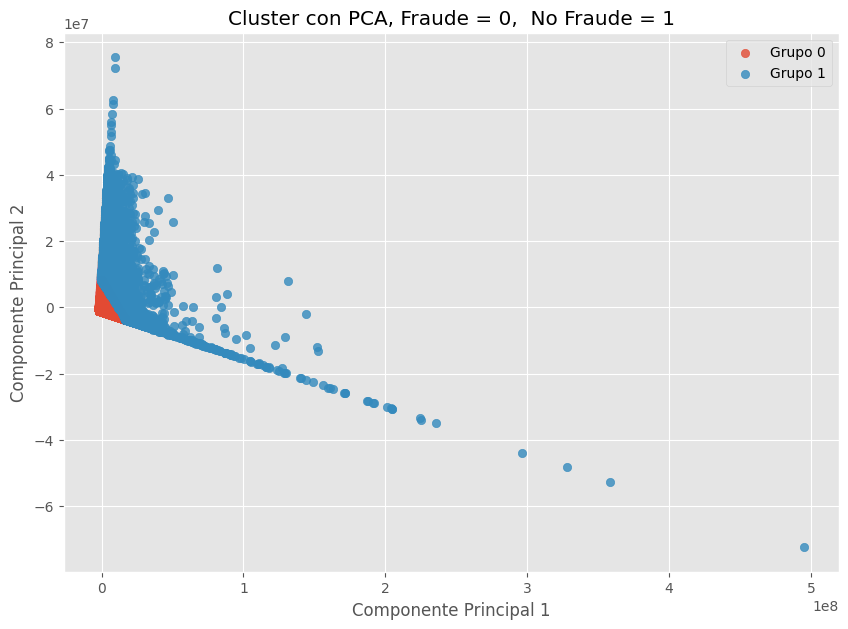

In [ ]:
from sklearn.decomposition import PCA

# APLICAR PCA PARA VISUALIZACIÓN
n_components = 2
pca = PCA(n_components=2)
pca.fit(dfRL)
data_pca = pca.transform(data_kmeans.iloc[:, :-1])
data_pca = pd.DataFrame(data_pca, columns=["PC1","PC2"])
data_pca["n_cluster"] = kmeans.labels_

plt.figure(figsize=(10, 7))
for cluster in data_pca['n_cluster'].unique():
    cluster_data = data_pca[data_pca['n_cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Grupo {cluster}', alpha=0.8)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Cluster con PCA, Fraude = 0,  No Fraude = 1')
plt.legend()
plt.show()

In [ ]:
dataRL.drop(columns=['isFraud'], inplace=True)

In [ ]:
#Grid Search manual para determinar los mejores valores epsilon y min_samples (mas de 3 horas)
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = np.arange(0.1, 22.0, 0.5)
min_samples_values = range(5, 100, 5)

best_score = -1 #el menor puntaje
best_params = {}

# Realiza la GridSearch
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(dataRL)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"eps: {eps}, min_samples: {min_samples}, n_clusters: {n_clusters}")

        # Solo calcula el puntaje silhouette si hay más de 1 cluster
        if n_clusters > 1:
            score = silhouette_score(dataRL, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Mejores parámetros: {best_params}")
print(f"Mejor puntaje silhouette: {best_score}")

eps: 0.1, min_samples: 5, n_clusters: 0
eps: 0.1, min_samples: 10, n_clusters: 0
eps: 0.1, min_samples: 15, n_clusters: 0
eps: 0.1, min_samples: 20, n_clusters: 0
eps: 0.1, min_samples: 25, n_clusters: 0
eps: 0.1, min_samples: 30, n_clusters: 0
eps: 0.1, min_samples: 35, n_clusters: 0
eps: 0.1, min_samples: 40, n_clusters: 0
eps: 0.1, min_samples: 45, n_clusters: 0
eps: 0.1, min_samples: 50, n_clusters: 0
eps: 0.1, min_samples: 55, n_clusters: 0
eps: 0.1, min_samples: 60, n_clusters: 0
eps: 0.1, min_samples: 65, n_clusters: 0
eps: 0.1, min_samples: 70, n_clusters: 0
eps: 0.1, min_samples: 75, n_clusters: 0
eps: 0.1, min_samples: 80, n_clusters: 0
eps: 0.1, min_samples: 85, n_clusters: 0
eps: 0.1, min_samples: 90, n_clusters: 0
eps: 0.1, min_samples: 95, n_clusters: 0
eps: 0.6, min_samples: 5, n_clusters: 0
eps: 0.6, min_samples: 10, n_clusters: 0
eps: 0.6, min_samples: 15, n_clusters: 0
eps: 0.6, min_samples: 20, n_clusters: 0
eps: 0.6, min_samples: 25, n_clusters: 0
eps: 0.6, min_samp

In [ ]:
# CLUSTERING DBSCAN
dbscan = DBSCAN(eps=20.1, min_samples=5, metric='euclidean')
dbscan.fit(dataRL)
dbscan_data = pd.DataFrame(dataRL).copy()
dbscan_data["n_cluster"] = dbscan.labels_
dbscan_data.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,n_cluster
0,0.0,0.0,0.0,0.0,1.0,134.0,1035299.74,51043.00,0.00,464953.59,1500253.34,-1
1,0.0,0.0,0.0,0.0,1.0,741.0,48442.88,48442.88,0.00,0.00,0.00,-1
2,0.0,1.0,0.0,0.0,0.0,162.0,2934820.94,2934820.94,0.00,123944.77,3058765.71,-1
3,0.0,0.0,0.0,0.0,1.0,404.0,10000000.00,12754759.04,2754759.04,0.00,0.00,-1
4,0.0,1.0,0.0,0.0,0.0,42.0,85844.69,19367.00,0.00,301824.00,387668.69,-1


Número de valores de ruido:  15978
Número de valores en el Cluster 1 10
Número de valores en el Cluster 0 7
Número de valores en el Cluster 2 5


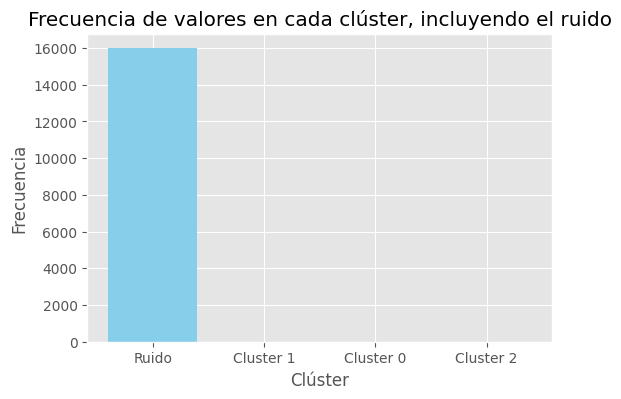

In [ ]:
unique_labels = dbscan_data["n_cluster"].unique().tolist()
labels_frequency = {}
for label in unique_labels:
  if label<0:
    labels_frequency["Ruido"] = len(dbscan_data[dbscan_data["n_cluster"] == -1])
    print("Número de valores de ruido: ", len(dbscan_data[dbscan_data["n_cluster"] == -1]))
  else:
    labels_frequency[f"Cluster {label}"] = len(dbscan_data[dbscan_data["n_cluster"] == label])
    print(f"Número de valores en el Cluster {label}",len(dbscan_data[dbscan_data["n_cluster"] == label]))

# Generar un gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(labels_frequency.keys(), labels_frequency.values(), color='skyblue')
plt.xlabel('Clúster')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de valores en cada clúster, incluyendo el ruido')
plt.show()

In [ ]:
n_components = 2
pca = PCA(n_components=2)
pca.fit(dfRL)
data_pca = pca.transform(dbscan_data.iloc[:, :-1]) # Aplicar PCA al DataFrame excluyendo la última, que es la que guarda las asignaciones a clústers.
data_pca = pd.DataFrame(data_pca, columns=["PC1","PC2"]) # Generamos
data_pca["n_cluster"] = dbscan.labels_

plt.figure(figsize=(10, 7))
for cluster in data_pca['n_cluster'].unique():
    cluster_data = data_pca[data_pca['n_cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.5)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA')
plt.legend()
plt.show()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- isFraud


#CONCLUSIONES FINALES

  Debido a que es un dataset forzado para el estudio o "fabricado", los 3 modelos de machine learning utilizados funcionan con exactitud superior al 90% y con una sensibilidad de casi el 100% por lo que podemos clasificar como fraude o no con cualquiera de los 3. Sin embargo, escojo el Random Forest por su robustez hacia el sobreajuste y su flexibilidad como modelo para ser adaptado en el futuro para otros cálculos. Inconsistencias como cantidades 0 desde balances 0 o transferencias y Cash outs de mas de 10M de dólares permanecen como outliers en el dataset ya que aunque sean anomalías podrían llegar a ocurrir si se trata de un fraude por lo tanto considero que eliminarlos o modificarlos podría significar sacrificar información.